# Cat and Dog Classification
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree for classification. 

In [11]:
import os
import numpy as np
from skimage.io import imread,imsave
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [12]:
# Load dataset
data_dir = './dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)
 
        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        img_resized = resize(img, (128, 128), anti_aliasing=True)
        images.append(img_resized)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [13]:
def data_2x_with_flipping(images,labels):
    """
    Add flipped version of every picture to dataset.

    Args:
    images: Array of grayscale images (N, 128, 128).
    labels: Array of labels (0 for cat, 1 for dog).

    Returns:
    final_images: Array of grayscale images (2*N, 128, 128).
    final_labels: Array of labels (0 for cat, 1 for dog).
    """

    final_images=list(images.copy())
    final_lables=list(labels.copy())

    for image,label in zip(images,labels):
        final_images.append(np.fliplr(image))
        final_lables.append(label)

    return np.array(final_images),np.array(final_lables)

In [14]:
def extract_hog_features(images,visualize=False,orientations=9,pixels_per_cell=(6,6),cells_per_block=(2,2),block_norm="L2-Hys"):
    """Extract HOG features from a list of grayscale images.
    
    Args:
        images: Array of grayscale images (N, 128, 128).
        visualize: If True, return HOG visualizations.
        orientations: Parameter of HOG
        pixels_per_cell: Parameter of HOG
        cells_per_block: Parameter of HOG
        block_norm: Parameter of HOG
    
    Returns:
        hog_features: Array of HOG features (N, feature_size).
        hog_images: Array of HOG visualizations (N, 128, 128) if visualize=True, else None.
    """

    #First empty lists
    hog_features=[]
    hog_images=[]

    #Images loop
    for image in images:
        #Use skimage hog with one or two based on visualize
        hogs=hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=visualize,
            block_norm=block_norm,
        )

        #Append data based on visualize
        if visualize:
            hog_features.append(hogs[0])
            hog_images.append(hogs[1])
        else:
            hog_features.append(hogs)

    #Return data as numpy array
    return np.array(hog_features),np.array(hog_images) if visualize else None

In [15]:
def split_and_save_dataset(images,labels,test_size=0.2,train_dir="./dog-cat/train",test_dir="./dog-cat/test"):
    """Split dataset into training and test sets and save images to separate directories.
    
    Args:
        images: Array of grayscale images (N, 128, 128).
        labels: Array of labels (0 for cat, 1 for dog).
        test_size: Fraction of data for test set.
        train_dir: Directory to save training images.
        test_dir: Directory to save test images.
    
    Returns:
        X_train: HOG features for training set.
        X_test: HOG features for test set.
        y_train: Labels for test set.
        y_test: Labels for training set.
        idx_train: Indices for test set.
        idx_test: Indices for training set.
    """

    #Create Folders
    os.makedirs(train_dir,exist_ok=True)
    os.makedirs(test_dir,exist_ok=True)

    #Array of indices
    idx=np.arange(images.shape[0])

    #Split all by observing the data ratio
    images_train,images_test,y_train,y_test,idx_train,idx_test=train_test_split(
        images,labels,idx,stratify=labels,
        test_size=test_size,random_state=42
    )

    #Saving training images
    for image,lable,i in zip(images_train,y_train,range(images_train.shape[0])):
        if lable==0:filename=f"cat.{i+1}.jpg"
        else:filename=f"dog.{i+1}.jpg"
        imsave(os.path.join(train_dir,filename),(image*255).astype(np.uint8))

    #Saving test images
    for image,lable,i in zip(images_test,y_test,range(images_test.shape[0])):
        if lable==0:filename=f"cat.{i+1}.jpg"
        else:filename=f"dog.{i+1}.jpg"
        imsave(os.path.join(test_dir,filename),(image*255).astype(np.uint8))
    
    #Extract HOG
    X_train,_=extract_hog_features(images_train)
    X_test,_=extract_hog_features(images_test)

    #Return all
    return X_train,X_test,y_train,y_test,idx_train,idx_test

In [16]:
def train_decision_tree(X_train,y_train,max_depth=3):
    """Train a Decision Tree classifier on HOG features.
    
    Args:
        X_train: HOG features for training (N_train, feature_size).
        y_train: Training labels (0 for cat, 1 for dog).
    
    Returns:
        clf: Trained Decision Tree classifier.
    """

    #Create tree and training
    clf=DecisionTreeClassifier(max_depth=max_depth,random_state=42)
    clf.fit(X_train,y_train)
    return clf

In [17]:
def train_random_forest(X_train,y_train,n_estimators=100,max_depth=3):
    """Train a Random Forest classifier on HOG features.
    
    Args:
        X_train: HOG features for training (N_train, feature_size).
        y_train: Training labels (0 for cat, 1 for dog).
    
    Returns:
        clf: Trained Random Forest classifier.
    """

    #Create random forest and training
    clf=RandomForestClassifier(n_estimators,max_depth=max_depth,random_state=42)
    clf.fit(X_train,y_train)
    return clf

In [18]:
def train_svc(X_train,y_train,kernel="rbf",C=1.0):
    """Train a SVC classifier on HOG features.
    
    Args:
        X_train: HOG features for training (N_train, feature_size).
        y_train: Training labels (0 for cat, 1 for dog).
    
    Returns:
        clf: Trained SVC classifier.
    """

    #Create svc and training
    clf=SVC(kernel=kernel,C=C,random_state=42)
    clf.fit(X_train,y_train)
    return clf

In [19]:
def evaluate_model(clf,X_test,y_test):
    """Evaluate the classifier on the test set.
    
    Args:
        clf: Trained classifier.
        X_test: HOG features for test set (N_test, feature_size).
        y_test: Test labels (0 for cat, 1 for dog).
    
    Returns:
        accuracy: Test set accuracy.
        y_pred: Predicted labels for test set.
    """

    #Predict test data and calculate accuracy
    y_pred=clf.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    return accuracy,y_pred

Test Accuracy: 0.9431


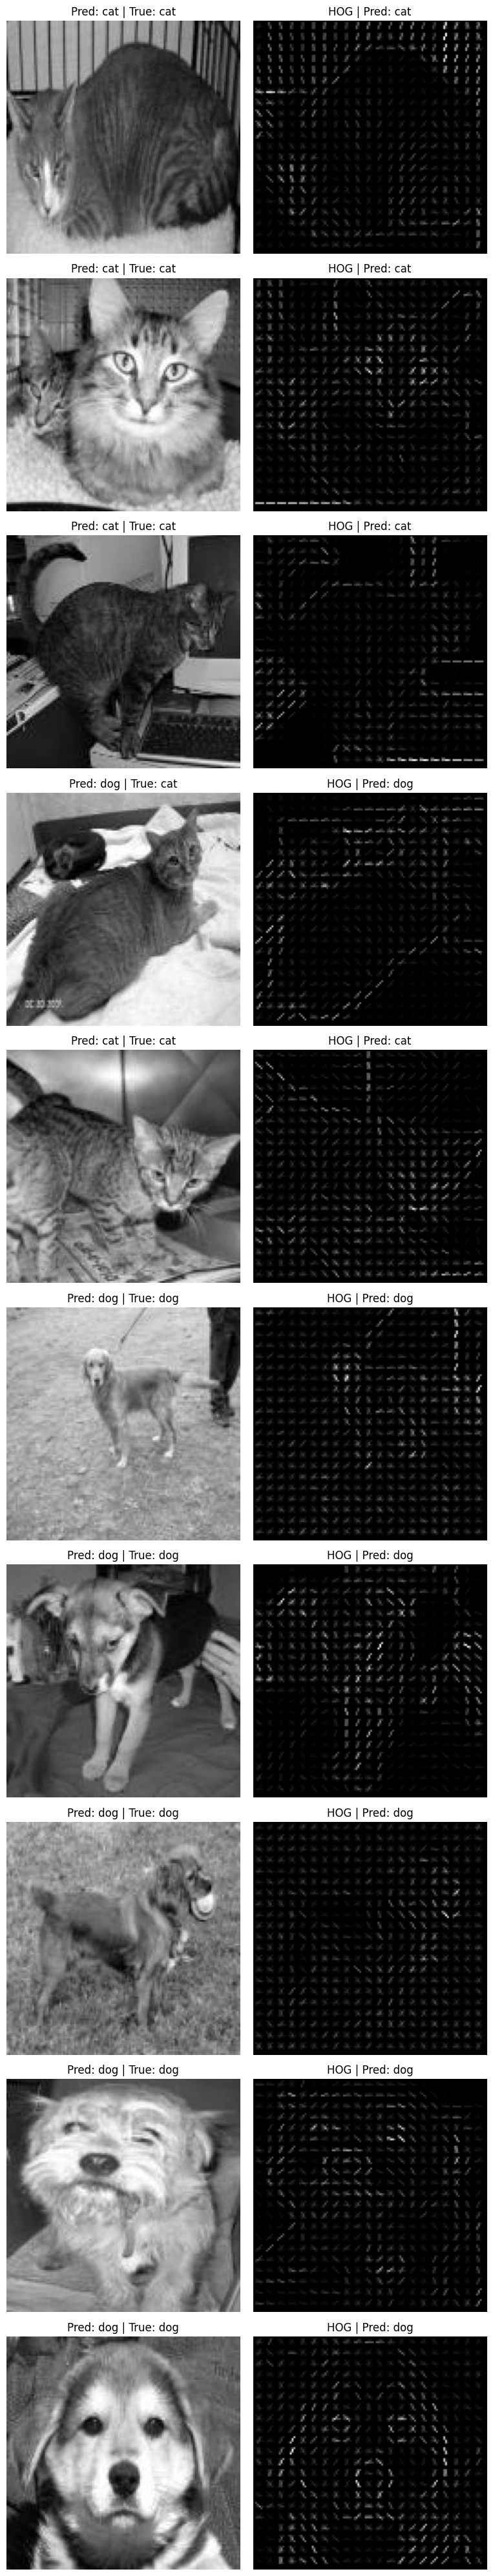

In [20]:
# Add flipped version to dataset
images,labels=data_2x_with_flipping(images,labels)

# Extract HOG features
hog_features, hog_images = extract_hog_features(images, visualize=True)

# Split and save dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = split_and_save_dataset(images, labels, test_size=0.2)

# Train
# clf = train_decision_tree(X_train, y_train)
# clf = train_random_forest(X_train, y_train)
clf = train_svc(X_train, y_train)

# Evaluate model
accuracy, y_pred = evaluate_model(clf, X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 2, figsize=(8, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    true_label = y_test[np.where(idx_test == idx)[0][0]]
    pred_label = y_pred[np.where(idx_test == idx)[0][0]]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'Pred: {classes[pred_label]} | True: {classes[true_label]}')
    ax.axis('off')

    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images[idx], cmap='gray')
    ax.set_title(f'HOG | Pred: {classes[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()